In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

In [132]:
runlist = np.arange(401, 405 , 1)
#runlist = [173, 174, 175, 177, 178]
Loaddir = '../Claudio/Reduced_XANES/'
pgroup = 'p20774'
##############################################
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))

Will load 4 runs: [401 402 403 404] from ../Claudio/Reduced_XANES/


## check data files

In [133]:
from itertools import chain
datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*XANES*npy*'.format(run))
    datafiles.append(file)
datafiles = itertools.chain.from_iterable(datafiles)
datafiles = sorted(datafiles, key = os.path.getmtime)
print ('{} files found'.format(len(datafiles)))
#datafiles    

[401 402 403 404]
36 files found


# Plotting averaged XANES  spectra (same X range)
### load and average data

In [134]:
diode_array = ['XANES_DataDiode1_pump', 'XANES_DataDiode1_unpump', 'XANES_Pump_probe_Diode1',
               'XANES_DataDiode2_pump', 'XANES_DataDiode2_unpump', 'XANES_Pump_probe_Diode2'
              ]

goodshots_array = ['XANES_goodshots1', 'XANES_goodshots2']

for file in glob.glob(Loaddir+'XANES*.npy'):
    os.remove(file)
    
for spec in diode_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,spec))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    spec2save = []
    if len(datafiles)>0:
        for ff in datafiles:
            spec2save.append(np.load(ff, allow_pickle=True))
        print (len(datafiles), spec, np.shape(spec2save))
        np.save(Loaddir+spec+'_all.npy', spec2save)
    else:
        print ('File not found for: {}'.format(spec))
    #print (len(patch), spec, np.shape(spec2save))
    #np.save(Loaddir+spec+'_all.npy', spec2save)
for item in goodshots_array:
    datafiles = []
    for run in runlist:
        file = glob.glob(Loaddir + '/*{:04d}*/{}.npy'.format(run,item))
        datafiles.append(file)
    datafiles = itertools.chain.from_iterable(datafiles)
    datafiles = sorted(datafiles, key = os.path.getmtime)
    goodshots2save = []
    if len(datafiles)>0:
        for ff in datafiles:
            goodshots2save.append(np.load(ff, allow_pickle=True))
        print (len(datafiles), item, np.shape(goodshots2save))
        np.save(Loaddir+item+'_all.npy', goodshots2save)  
    else:
        print ('File not found for: {}'.format(item))

4 XANES_DataDiode1_pump (4, 51, 3)
4 XANES_DataDiode1_unpump (4, 51, 3)
4 XANES_Pump_probe_Diode1 (4, 51, 3)
4 XANES_DataDiode2_pump (4, 51, 3)
4 XANES_DataDiode2_unpump (4, 51, 3)
4 XANES_Pump_probe_Diode2 (4, 51, 3)
4 XANES_goodshots1 (4, 51)
4 XANES_goodshots2 (4, 51)


In [135]:
DataDiode1_pump_all = np.load(Loaddir+'/XANES_DataDiode1_pump_all.npy', allow_pickle=True)
DataDiode1_unpump_all = np.load(Loaddir+'/XANES_DataDiode1_unpump_all.npy', allow_pickle=True)
Pump_probe1_all = np.load(Loaddir+'/XANES_Pump_probe_Diode1_all.npy', allow_pickle=True)
goodshots1_all = np.load(Loaddir+'/XANES_goodshots1_all.npy',allow_pickle=True)
try:
    DataDiode2_pump_all = np.load(Loaddir+'/XANES_DataDiode2_pump_all.npy', allow_pickle=True)
    DataDiode2_unpump_all = np.load(Loaddir+'/XANES_DataDiode2_unpump_all.npy', allow_pickle=True)
    Pump_probe2_all = np.load(Loaddir+'/XANES_Pump_probe_Diode2_all.npy', allow_pickle=True)
    goodshots2_all = np.load(Loaddir+'/XANES_goodshots2_all.npy', allow_pickle=True)
except:
    print ('Diode2 files not found')

In [136]:
#### CH1 ####
XAS1_pump        = np.mean(DataDiode1_pump_all[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump_all[:,:,0]-DataDiode1_pump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump_all[:,:,2]-DataDiode1_pump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump_all[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump_all[:,:,0]-DataDiode1_unpump_all[:,:,1])/np.sqrt(goodshots1_all), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump_all[:,:,2]-DataDiode1_unpump_all[:,:,0])/np.sqrt(goodshots1_all), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe1_all[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
try:
    XAS2_pump        = np.mean(DataDiode2_pump_all[:,:,0], axis=0)
    err2_low_pump    = np.mean((DataDiode2_pump_all[:,:,0]-DataDiode2_pump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
    err2_high_pump   = np.mean((DataDiode2_pump_all[:,:,2]-DataDiode2_pump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

    XAS2_unpump      = np.mean(DataDiode2_unpump_all[:,:,0], axis=0)
    err2_low_unpump  = np.mean((DataDiode2_unpump_all[:,:,0]-DataDiode2_unpump_all[:,:,1])/np.sqrt(goodshots2_all), axis=0)
    err2_high_unpump = np.mean((DataDiode2_unpump_all[:,:,2]-DataDiode2_unpump_all[:,:,0])/np.sqrt(goodshots2_all), axis=0)

    XAS2_pump_probe       = np.mean(Pump_probe2_all[:,:,0], axis=0)
    err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
    err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
except:
    print ('Diode2 files not found')

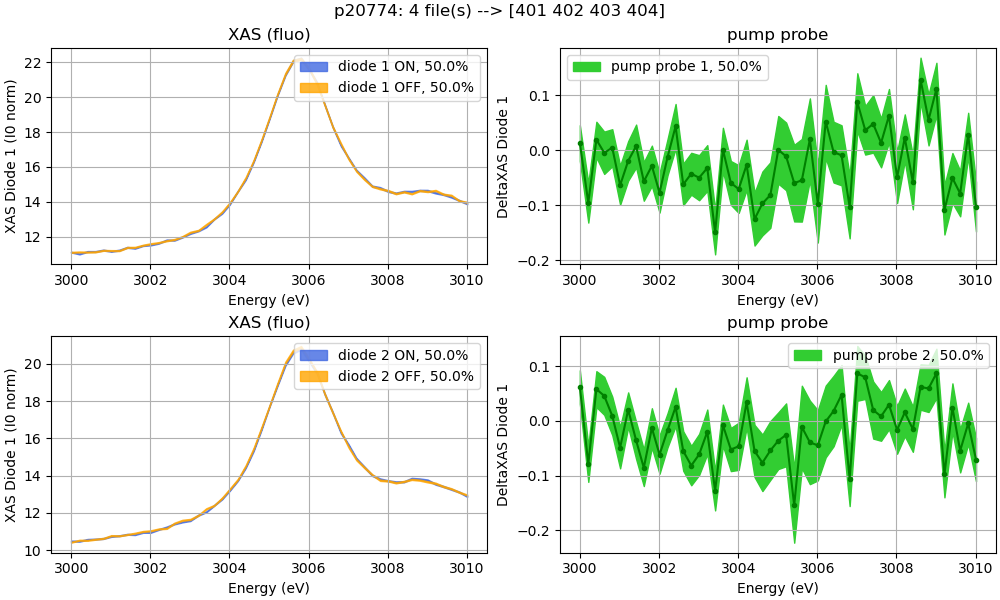

In [137]:
quantile_corr = 0.5

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
plt.suptitle('{}: {} file(s) --> {}'.format(pgroup, len(runlist),str(runlist)))

ff = glob.glob(Loaddir+'/*{:04d}*/XANES_energy_eV.npy'.format(runlist[0]))
Energy_eV = np.load(ff[0])

ax1.fill_between(Energy_eV, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump , label='diode 1 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax1.fill_between(Energy_eV, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax3.fill_between(Energy_eV, XAS1_pump_probe - err1_low_pump_probe, XAS1_pump_probe + err1_low_pump_probe, label='pump probe 1, {}%'.format(quantile_corr*100),color='limegreen')
ax3.plot(Energy_eV, XAS1_pump_probe, color='green', marker='.')
#ax3.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))
try:
    ax2.fill_between(Energy_eV, XAS2_pump - err2_low_pump, XAS2_pump + err2_high_pump , label='diode 2 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
    ax2.fill_between(Energy_eV, XAS2_unpump - err2_low_unpump, XAS2_unpump + err2_high_unpump, label='diode 2 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
    ax4.fill_between(Energy_eV, XAS2_pump_probe - err2_low_pump_probe, XAS2_pump_probe + err2_low_pump_probe, label='pump probe 2, {}%'.format(quantile_corr*100),color='limegreen')
    ax4.plot(Energy_eV, XAS2_pump_probe, color='green', marker='.')
    #ax4.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))
except:
    print ('Diode2 files not found')

ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax3.set_xlabel("Energy (eV)")
ax3.set_ylabel ("DeltaXAS Diode 1")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("XAS Diode 1 (I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax4.set_xlabel("Energy (eV)")
ax4.set_ylabel ("DeltaXAS Diode 1")
ax4.set_title('pump probe')
ax4.legend(loc="best")
ax4.grid()

plt.show()

## Average the 2 diodes

In [138]:
##Average first, subtract later

ave_unpump = (XAS1_unpump-np.mean(XAS1_unpump[0:5]) + XAS2_unpump-np.mean(XAS2_unpump[0:5]))/2        ### subtracts the baseline
ave_unpump_err_l = np.sqrt(err1_low_unpump**2+err2_low_unpump**2)
ave_unpump_err_h = np.sqrt(err1_high_unpump**2+err1_high_unpump**2)

ave_pump = (XAS1_pump-np.mean(XAS1_pump[0:5]) + XAS2_pump-np.mean(XAS2_pump[0:5]))/2                  ### subtracts the baseline
ave_pump_err_l = np.sqrt(err1_low_pump**2+err2_low_pump**2)
ave_pump_err_h = np.sqrt(err1_high_pump**2+err1_high_pump**2)

ave_pp1 = ave_pump - ave_unpump
ave_pp_err_l1 = np.sqrt(ave_unpump_err_l**2+ave_pump_err_l**2)
ave_pp_err_h1 = np.sqrt(ave_unpump_err_h**2+ave_pump_err_h**2)

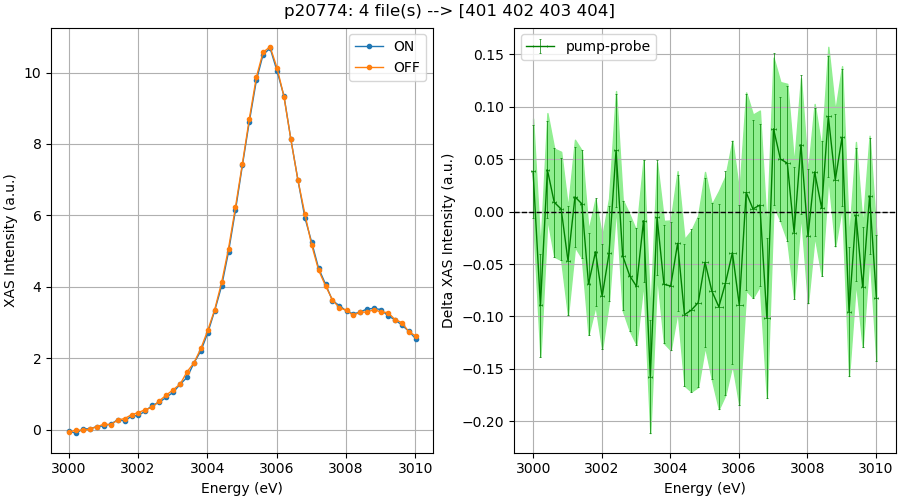

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle('{}: {} file(s) --> {}'.format(pgroup,len(runlist),str(runlist)))

ax1.plot(Energy_eV,ave_pump,lw=1,marker='o',markersize=3,label='ON')
ax1.plot(Energy_eV,ave_unpump,lw=1,marker='o',markersize=3,label='OFF')
ax1.grid()
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.legend()

## Difference of the Averages (probably more correct)
ax2.axes.errorbar(Energy_eV, ave_pp1, ave_pp_err_l1, ave_pp_err_h1, 
              lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                   ecolor='green',elinewidth=0.5,label='pump-probe')
ax2.fill_between(Energy_eV,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen')

ax2.grid()
ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Delta XAS Intensity (a.u.)')
ax2.legend()
plt.show()

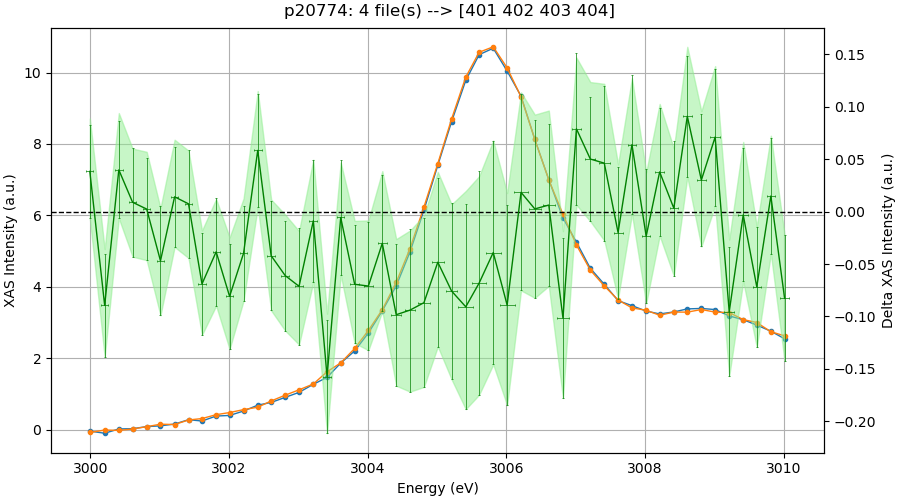

In [140]:
fig, ax1= plt.subplots(1, 1, figsize=(9, 5), constrained_layout=True)
plt.suptitle('{}: {} file(s) --> {}'.format(pgroup,len(runlist),str(runlist)))

ax1.plot(Energy_eV,ave_pump,lw=1,marker='o',markersize=3,label='ON') 
ax1.plot(Energy_eV,ave_unpump,lw=1,marker='o',markersize=3,label='ON') 
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.grid()
ax1.set_xlabel('Energy (eV)')

ax2 = plt.twinx(ax1)
ax2.axes.errorbar(Energy_eV, ave_pp1, ave_pp_err_l1, ave_pp_err_h1, 
              lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                   ecolor='green',elinewidth=0.5,label='pump-probe')
ax2.fill_between(Energy_eV,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen', alpha=0.5)
ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_ylabel('Delta XAS Intensity (a.u.)')
plt.show()

## save the averaged spectra to load them overlaid

In [69]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_XANES/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

DataDiode1_pump_avg   = np.mean(DataDiode1_pump_all[:,:,:], axis=0)
DataDiode1_unpump_avg = np.mean(DataDiode1_unpump_all[:,:,:], axis=0)
Pump_probe1_avg       = np.mean(Pump_probe1_all[:,:,:], axis=0)
goodshots1_avg        = np.mean(goodshots1_all, axis=0)

save_run_array_XANES(reducedir, run_name, Energy_eV, DataDiode1_pump_avg, DataDiode1_unpump_avg, Pump_probe1_avg, goodshots1_avg)
print (reducedir+run_name)

../Claudio/Reduced_XANES/averaged/run0056-Fe2_CytC_XAS_5000fs_1.1uJ


# Overlay different XANES  spectra
### load data

In [2]:
#runlist = np.arange(246, 249, 1)
runlist = [17, 18, 19, 21, 22]
Loaddir = '../Claudio/Reduced_XANES/'
##############################################
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*npy*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 5 runs: [17, 18, 19, 21, 22] from ../Claudio/Reduced_XANES/


['../Claudio/Reduced_XANES/run0017-Rubpy_XAS/run_array.npy',
 '../Claudio/Reduced_XANES/run0018-Rubpy_XAS/run_array.npy',
 '../Claudio/Reduced_XANES/run0019-Rubpy_XAS/run_array.npy',
 '../Claudio/Reduced_XANES/run0021-Rubpy_XAS/run_array.npy',
 '../Claudio/Reduced_XANES/run0022-Rubpy_XAS/run_array.npy']

# TWO DIODES

No handles with labels found to put in legend.


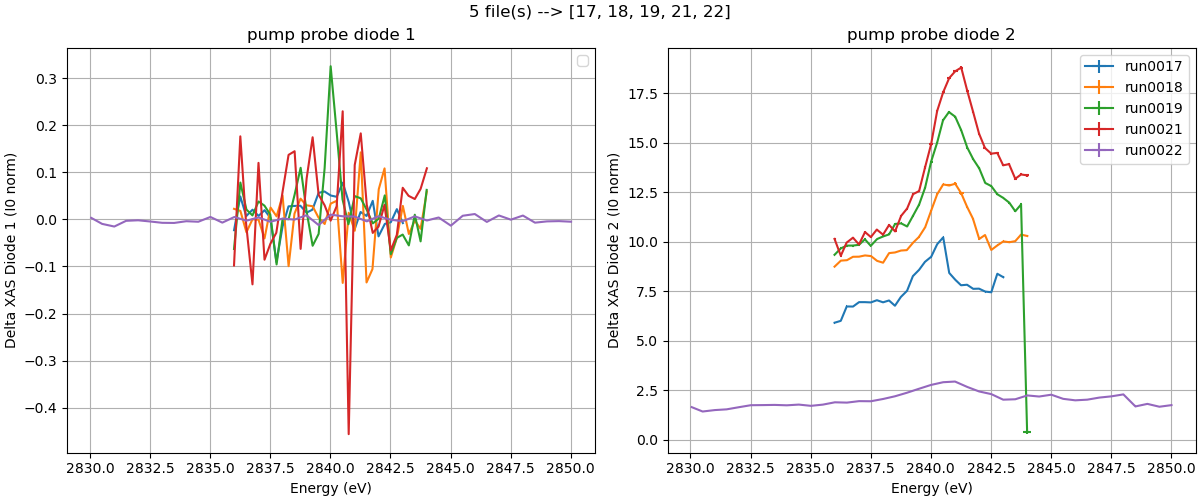

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.plot(Energy_eV, XAS1_pump_probe[:,0])
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_unpump, err1_high_unpump, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
        try:
            XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
            D2p = run_array[key]["DataDiode2_pump"]
            D2u = run_array[key]["DataDiode2_unpump"]
            gs2 = run_array[key]["goodshots2"]
            
            err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
            err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
            err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
            err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)
        
            err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
            err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
            
            #ax2.plot(Energy_eV, XAS2_pump_probe[:,0])
            ax2.axes.errorbar(Energy_eV, D2u[:,0], err2_low_unpump, err2_high_unpump, label=runnumber)
        
        except:
            print ('Diode2 files not found')
        
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("Delta XAS Diode 2 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe diode 1')
ax2.set_title('pump probe diode 2')

plt.show()

# ONE diode

IndexError: list index out of range

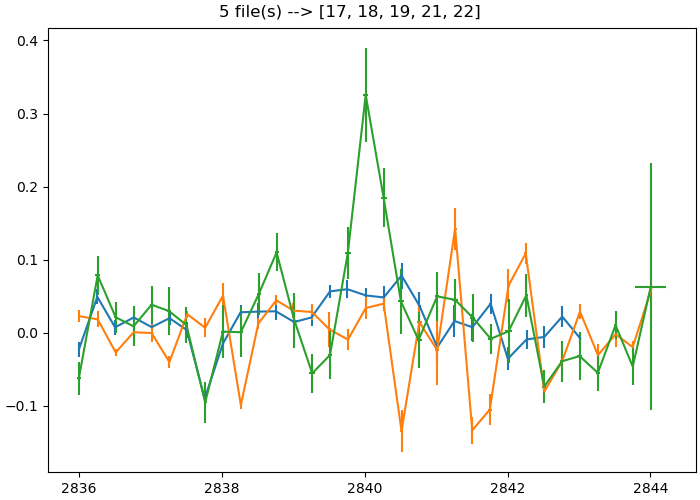

In [4]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

labels = ['300 fs', '1 ps','5 ps']

for i, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

ax1.vlines(x=[2469.5, 2470.6, 2472.5, 2473.5, 2474.75, 2480], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('pump probe diode 1')

plt.show()

### convert npy to mat files

In [204]:
Loaddir = '../Claudio/Reduced_timescans/averaged/'

import scipy.io
f = glob.glob(Loaddir + '/*/*.npy*')

for file in f:
    temp = np.load(file, allow_pickle=True)
    mdic = {"data": temp,}
    fname = file.split('/')[-1].split('.')[0]
    path = os.path.dirname(file) + '/' + fname
    print (path + '/' + fname)
    scipy.io.savemat(path +'.mat', mdic)

../Claudio/Reduced_timescans/averaged/run0059-Fe2_CytC_time_scan_2473eV_1.1uJ/run_array/run_array
../Claudio/Reduced_timescans/averaged/run0086-Fe2_CytC_time_scan_2478eV_1.1uJ/run_array/run_array
../Claudio/Reduced_timescans/averaged/run0088-Fe2_CytC_time_scan_2472eV_1.1uJ/run_array/run_array
../Claudio/Reduced_timescans/averaged/run0066-Fe2_CytC_time_scan_2473eV_1.1uJ/run_array/run_array
../Claudio/Reduced_timescans/averaged/run0063-Fe2_CytC_time_scan_2471eV_1.1uJ/run_array/run_array
../Claudio/Reduced_timescans/averaged/run0060-Fe2_CytC_time_scan_2466.5eV_1.1uJ/run_array/run_array
../Claudio/Reduced_timescans/averaged/run0058-Fe2_CytC_time_scan_2473eV_1.1uJ/run_array/run_array
../Claudio/Reduced_timescans/averaged/run0065-Fe2_CytC_time_scan_2474eV_1.1uJ/run_array/run_array
../Claudio/Reduced_timescans/averaged/run0085-Fe2_CytC_time_scan_2478eV_1.1uJ/run_array/run_array
../Claudio/Reduced_timescans/averaged/run0062-Fe2_CytC_time_scan_2471eV_1.1uJ/run_array/run_array
../Claudio/Reduced